# Import Librerie

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Definizione funzioni

In [2]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return torch.sqrt(torch.mean(torch.square(actual - predicted)))

In [3]:
def getRemoteDataset():
    return pd.read_csv('https://raw.githubusercontent.com/Uniba-dev-projects/forecasting-framework/synthetic_dataset_analysis/synthetic_dataset/synthetic_dataset.csv')    

In [4]:
def extractDataframeAndSeries(key, dataset):
    df = dataset[[key]]
    df = df.rename(columns={key: "t"}).reset_index()
    df.series = df.t.str.replace(",",".", regex=True).astype(float)
    return df, df.series.squeeze().dropna()

In [5]:
def calculateLoss(y, y_predicted):
    loss = []
    for i in range(len(y)):
        loss.append(abs(y[i]-y_predicted[i]))
    return loss

In [6]:
def showPerformanceGraph(label, portion, y_train, y_test, y_predicted_train, y_predicted_test, loss_train, loss_test, rmse_train, rmse_test):
    total = len(y_train) + len(y_test)
    plt.figure(figsize=(30,5))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(0, total, 1), np.concatenate((y_train, y_test), axis=0))
    plt.plot(np.arange(0, total, 1), np.concatenate((y_predicted_train, y_predicted_test), axis=0))
    plt.legend(["Series", "Predicted", "Train and test set splitter"])

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(0, total, 1), np.concatenate((loss_train, loss_test), axis=0))
    plt.legend(["Loss", "Train and test set splitter"])

    plt.subplot(1, 3, 3)
    plt.plot(rmse_train)
    plt.plot(rmse_test)
    plt.title("Last RMSE Train = "+str(rmse_train[-1])+"\n Last RMSE Test = "+str(rmse_test[-1]))
    plt.legend(["RMSE Train", "RMSE Test"])
    
    plt.suptitle(label)

# Inizializzazione e Visualizzazione Serie Temporali Sintentiche

In [7]:
dataset = getRemoteDataset()
_, series1 = extractDataframeAndSeries('y1(t) = t/1000 = y1(t-1)+0.001', dataset)
_, series2 = extractDataframeAndSeries('y2(t)=y2(t-1)*0.999', dataset)
_, series3 = extractDataframeAndSeries('y3(t)=y1(t)+y2(t)', dataset)
_, series4 = extractDataframeAndSeries('y4(t) = y4(t-1)-0.001', dataset)
_, series5 = extractDataframeAndSeries('y5(t)=y1(t)*t%2+y4(t)*(1-t%2)', dataset)
_, series6 = extractDataframeAndSeries('y6(t)=sin(t)', dataset)

<AxesSubplot:xlabel='x', ylabel='y'>

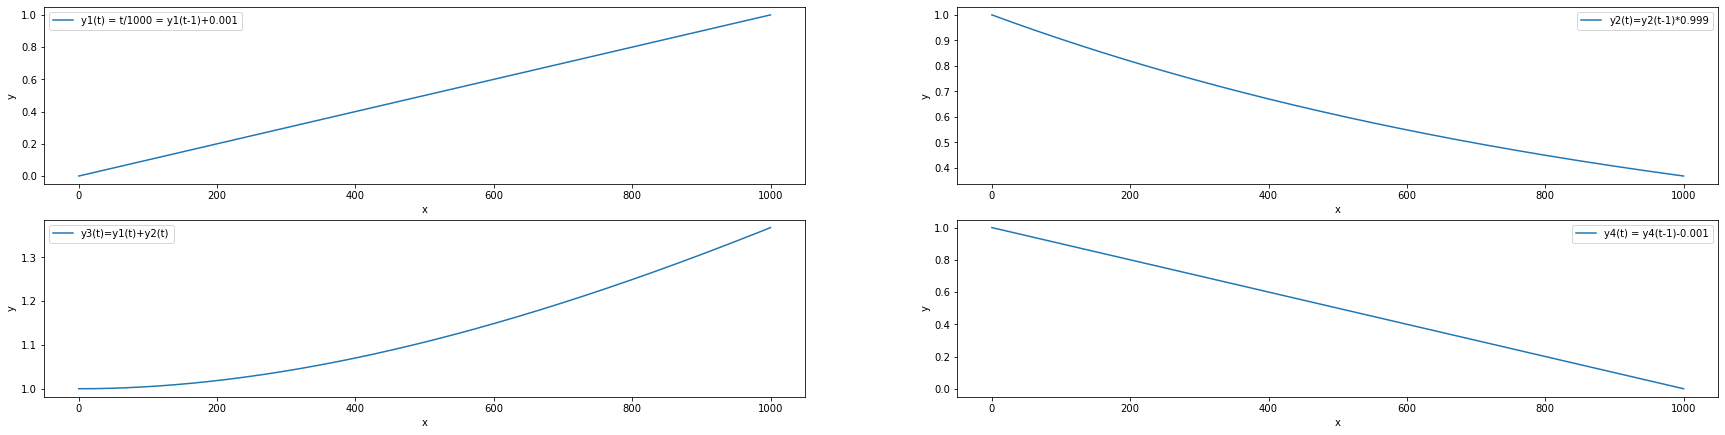

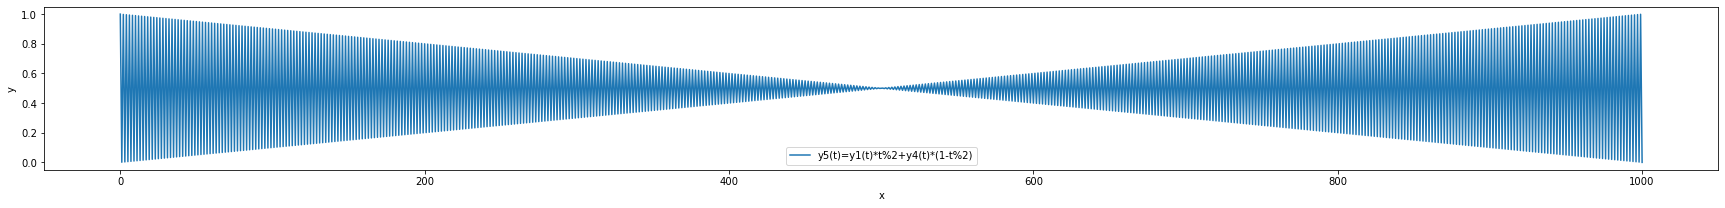

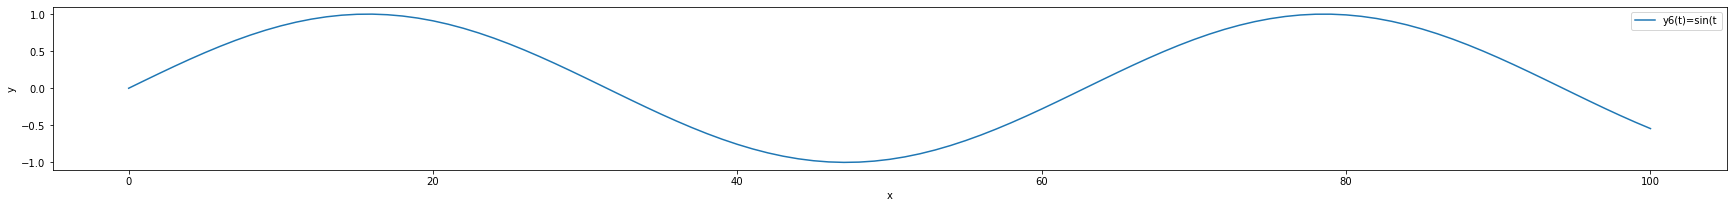

In [9]:
plt.figure(figsize=(30,15))

plt.subplot(4, 2, 1)
series1.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y1(t) = t/1000 = y1(t-1)+0.001")

plt.subplot(4, 2, 2)
series2.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y2(t)=y2(t-1)*0.999")

plt.subplot(4, 2, 3)
series3.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y3(t)=y1(t)+y2(t)")

plt.subplot(4, 2, 4)
series4.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y4(t) = y4(t-1)-0.001")

plt.figure(figsize=(30,3))
series5.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y5(t)=y1(t)*t%2+y4(t)*(1-t%2)")

plt.figure(figsize=(30,3))
series6.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y6(t)=sin(t")

# DatasetManager e Inizializzazione Long Short Term Memory
DatasetManager restituisce da una serie temporale un pandas.DataFrame definendo il nuemro di feature e il numero di variabili target.

In [10]:
class DatasetManager():
    def __getPandasFromNumpySeries(self, series, features_sequences=1, target_sequences=1, offset=0):

        dfTemp = pd.DataFrame({"ref": series})
        dfTemp.ref = dfTemp.ref.astype(float)
        for i in range(target_sequences):
            dfTemp['t+'+str(target_sequences-i)] = dfTemp.ref.shift(i)

        dfTemp['t'] = dfTemp.ref.shift(target_sequences)

        for j in range(features_sequences-1):
            dfTemp['t-'+str(j+1)] = dfTemp.ref.shift(target_sequences+j+1)

        dfTemp.drop(columns=["ref"], inplace=True)
        dropLine = features_sequences+target_sequences-1

        if(offset > 0):
            dfTemp['t'] = dfTemp['t'].shift(offset)
            for i in range(features_sequences-1):
                dfTemp['t-'+str(i+1)] = dfTemp['t-'+str(i+1)].shift(offset)
        
        dfTemp.drop(np.arange(0, dropLine+offset), inplace=True)
    
        return dfTemp[dfTemp.columns[::-1]].reset_index().drop(columns=["index"])
    
    def __getScaledDataFrame(self, df):
        tempColumns = df.columns
        scaler = MinMaxScaler()
        scalerDf = scaler.fit(df.to_numpy())
        df_scaled = scalerDf.transform(df)
        return pd.DataFrame(df_scaled, columns=tempColumns)

    def __init__(self, sequences, features_sequences=1, target_sequences=1, offset=0, portion=0.8):
        self.sequences = sequences
        self.features_sequences = features_sequences
        self.target_sequences = target_sequences
        self.offset = offset
        self.portion = portion
        tempDf = self.__getPandasFromNumpySeries(sequences, features_sequences, target_sequences, offset)
        self.df = self.__getScaledDataFrame(tempDf)

    def __len__(self):
        return len(self.sequences)

    def __get_x_y(self):
      return self.df[self.df.columns[0:self.features_sequences]].to_numpy(), self.df[self.df.columns[self.features_sequences:]].to_numpy()


    def __train_and_test_set__(self):
      x, y = self.__get_x_y()
      X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
      return torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    def __get_entire_series__(self):
      x, y = self.__get_x_y()
      return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
 


In [11]:
class LSTM_Predictor(nn.Module):

    def __init__(self, input_dim):
        super(LSTM_Predictor, self).__init__()
        
        self.input_dim = input_dim
        self.lstm = nn.LSTM(
            input_size = input_dim,
            hidden_size = 128,
            num_layers = 2,
            dropout = .1
        )
        self.linear = nn.Linear(in_features=128, out_features=1)

    def forward(self, sequences):
        y_lstm, _ = self.lstm(sequences)
        y_pred = self.linear(y_lstm)
        return y_pred

In [12]:
def executeLSTM(label, series, feature_sequences=1, target_sequences=1, portion=0.8, offset=0, num_epochs=25):
    dataset = DatasetManager(
        series,
        features_sequences=feature_sequences,
        target_sequences=target_sequences,
        portion=portion,
        offset=offset
    )
    X_train, X_test, y_train, y_test = dataset.__train_and_test_set__()

    lstm = LSTM_Predictor(feature_sequences)
    optimizer = optim.Adam(lstm.parameters(), lr=0.001)

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    for t in range(num_epochs):
        y_train_pred = lstm(X_train)
        loss = RMSE_Loss(y_train, y_train_pred)

        lstm.eval()
        with torch.no_grad():
            y_test_pred = lstm(X_test)
            test_loss = RMSE_Loss(y_test, y_test_pred)
            test_hist[t] = test_loss.item()

        if(t%10 == 0):
          print(f'Epoch {t} train loss:{loss.item()} test loss: {test_loss.item()}')
        
        train_hist[t] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    showPerformanceGraph(
        label = label,
        portion=portion,
        y_train=y_train.squeeze(),
        y_test=y_test.squeeze(),
        y_predicted_train=y_train_pred.detach().numpy().flatten(),
        y_predicted_test=y_test_pred.detach().numpy().flatten(),
        loss_train=calculateLoss(y_train.squeeze(), y_train_pred.detach().numpy().flatten()),
        loss_test=calculateLoss(y_test.squeeze(), y_test_pred.detach().numpy().flatten()),
        rmse_train=train_hist,
        rmse_test=test_hist
    )

    x_series, y_series = dataset.__get_entire_series__()
    lstm.eval()
    with torch.no_grad():
        yhat_series = lstm(x_series)
        plt.figure(figsize=(25,5))
        plt.plot(y_series.detach().numpy())
        plt.plot(yhat_series.detach().numpy())
        plt.legend(["True", "Predicted"])


# Esecuzione Long Short Term Memory

In [19]:
features_length = 5 #Default 1 (Sostituire i valori per gli esperimenti)
offset = 3 #Default 0 (Sostituire i valori per gli esperimenti)
portion_train_test = 0.8 #Default 0.8 (Sostituire i valori per gli esperimenti)
num_epochs = 150

Epoch 0 train loss:0.622519314289093 test loss: 0.6340022087097168
Epoch 10 train loss:0.30174487829208374 test loss: 0.29902127385139465
Epoch 20 train loss:0.27928170561790466 test loss: 0.281912624835968
Epoch 30 train loss:0.26984119415283203 test loss: 0.2719336748123169
Epoch 40 train loss:0.25692930817604065 test loss: 0.2585809528827667
Epoch 50 train loss:0.23028972744941711 test loss: 0.23368071019649506
Epoch 60 train loss:0.1677362322807312 test loss: 0.168690025806427
Epoch 70 train loss:0.07708930969238281 test loss: 0.07349850982427597
Epoch 80 train loss:0.03740338981151581 test loss: 0.04267432168126106
Epoch 90 train loss:0.029979119077324867 test loss: 0.03637124225497246
Epoch 100 train loss:0.017053406685590744 test loss: 0.023956185206770897
Epoch 110 train loss:0.012547843158245087 test loss: 0.019705498591065407
Epoch 120 train loss:0.009616026654839516 test loss: 0.01745118573307991
Epoch 130 train loss:0.022266434505581856 test loss: 0.026502085849642754
Epoch

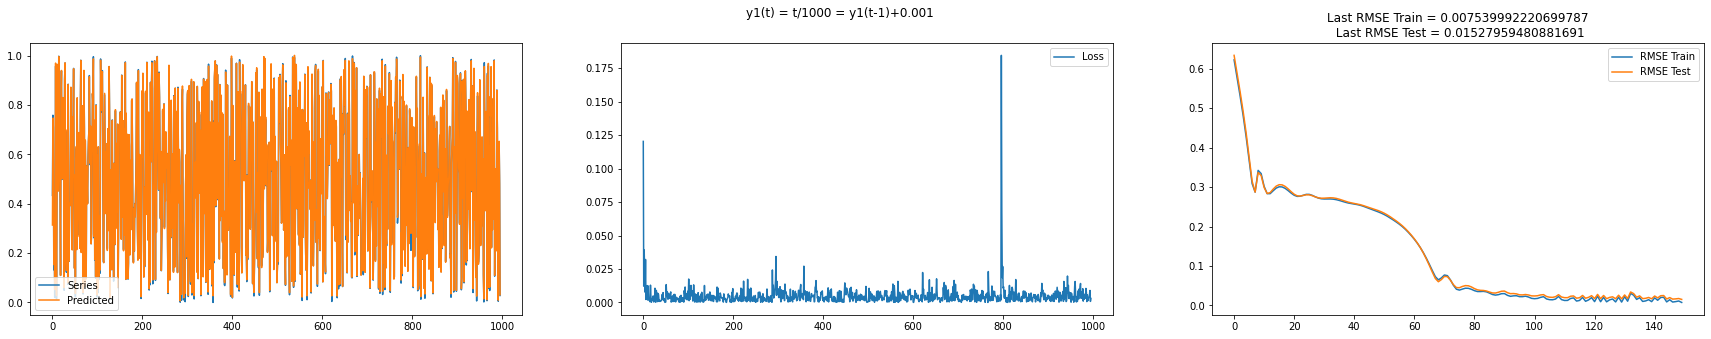

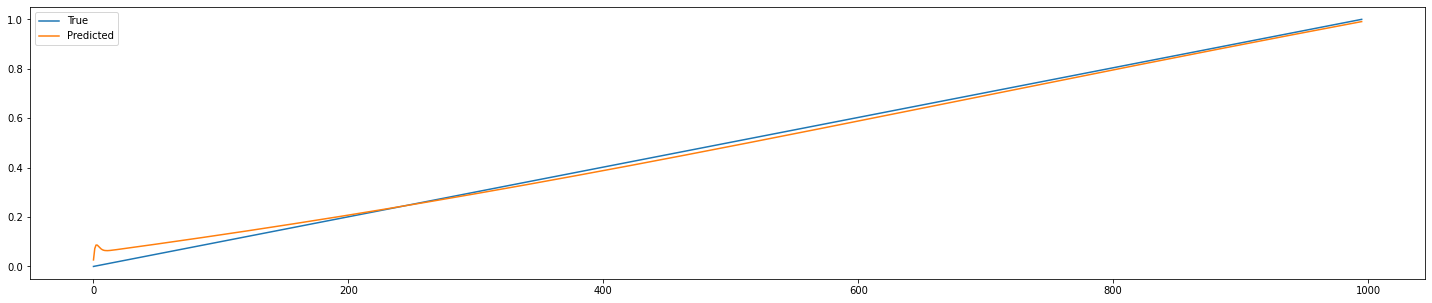

In [ ]:
executeLSTM("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.5359277725219727 test loss: 0.5330564975738525
Epoch 10 train loss:0.2980489730834961 test loss: 0.29764172434806824
Epoch 20 train loss:0.2762128710746765 test loss: 0.27464622259140015
Epoch 30 train loss:0.26214277744293213 test loss: 0.26108235120773315
Epoch 40 train loss:0.24192510545253754 test loss: 0.24149981141090393
Epoch 50 train loss:0.1969607025384903 test loss: 0.19721373915672302
Epoch 60 train loss:0.06824802607297897 test loss: 0.06505594402551651
Epoch 70 train loss:0.04567587003111839 test loss: 0.04780978336930275
Epoch 80 train loss:0.02662058174610138 test loss: 0.026884131133556366
Epoch 90 train loss:0.02219502255320549 test loss: 0.02235119417309761
Epoch 100 train loss:0.017686663195490837 test loss: 0.017659461125731468
Epoch 110 train loss:0.010757415555417538 test loss: 0.011203871108591557
Epoch 120 train loss:0.013949215412139893 test loss: 0.013955969363451004
Epoch 130 train loss:0.008507803082466125 test loss: 0.008278017863631248

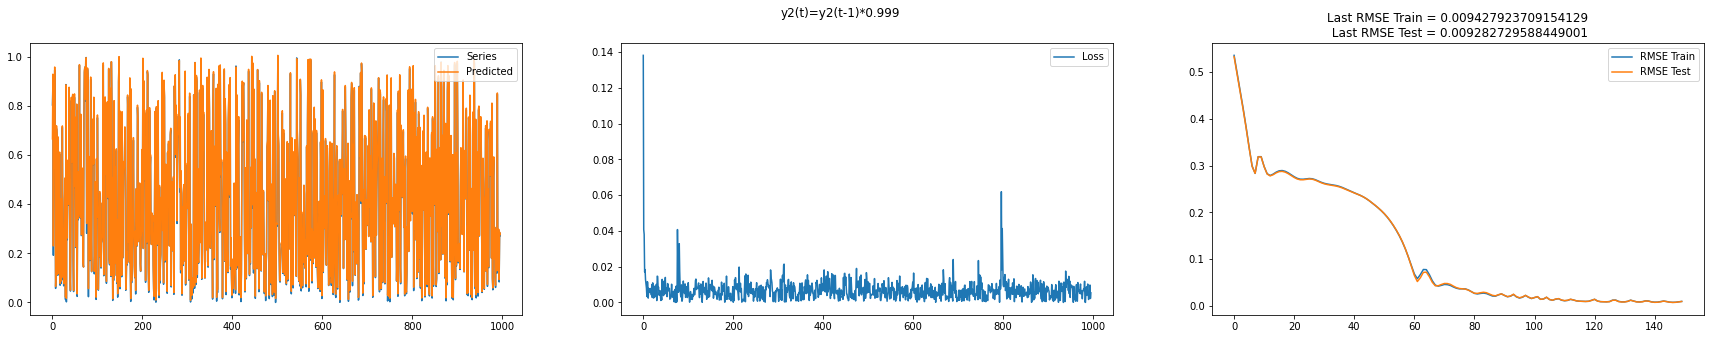

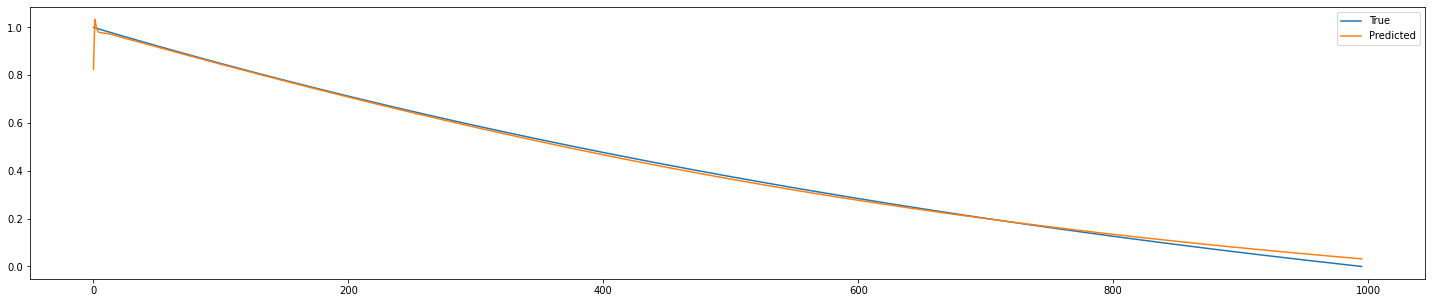

In [ ]:
executeLSTM("y2(t)=y2(t-1)*0.999", series2, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.47584596276283264 test loss: 0.4814457595348358
Epoch 10 train loss:0.3079344928264618 test loss: 0.3128385841846466
Epoch 20 train loss:0.2943982481956482 test loss: 0.301466703414917
Epoch 30 train loss:0.27966704964637756 test loss: 0.2854366898536682
Epoch 40 train loss:0.2512214779853821 test loss: 0.2570071816444397
Epoch 50 train loss:0.1744156777858734 test loss: 0.18195000290870667
Epoch 60 train loss:0.05756828933954239 test loss: 0.0658060610294342
Epoch 70 train loss:0.036961879581213 test loss: 0.04212060943245888
Epoch 80 train loss:0.023747995495796204 test loss: 0.028906656429171562
Epoch 90 train loss:0.024768324568867683 test loss: 0.026705145835876465
Epoch 100 train loss:0.015909582376480103 test loss: 0.0200502872467041
Epoch 110 train loss:0.010111202485859394 test loss: 0.016962246969342232
Epoch 120 train loss:0.008706117980182171 test loss: 0.015851711854338646
Epoch 130 train loss:0.01240652147680521 test loss: 0.01842411980032921
Epoch 14

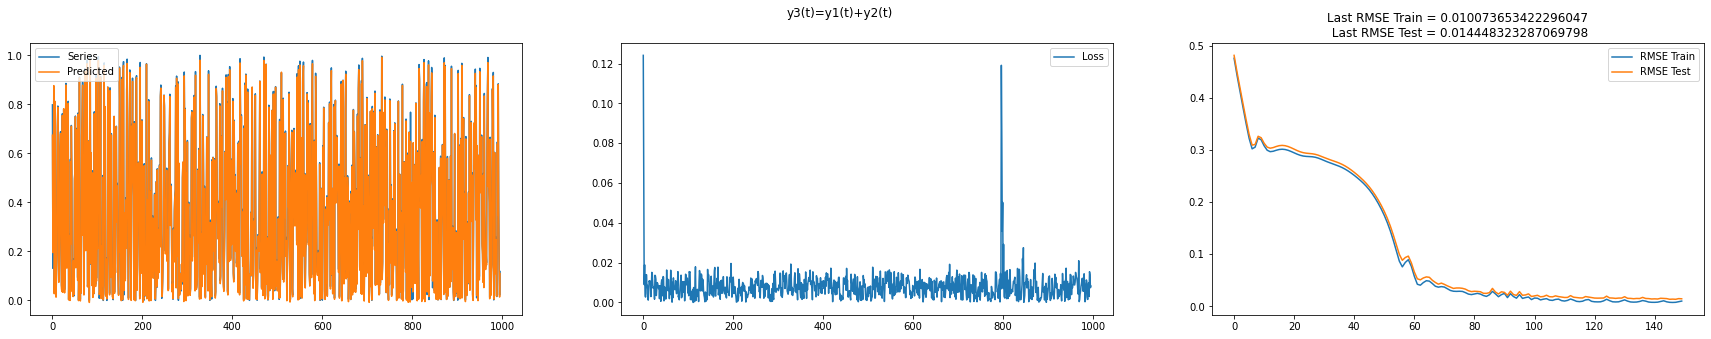

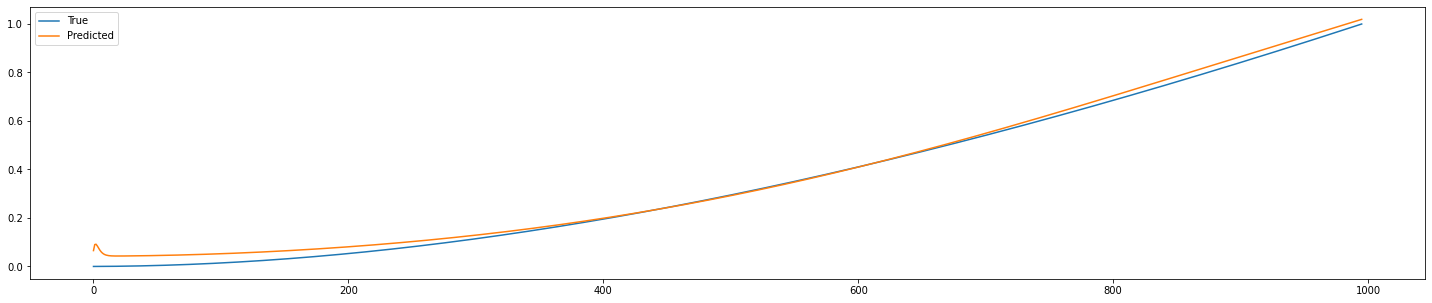

In [ ]:
executeLSTM("y3(t)=y1(t)+y2(t)", series3, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.6136376857757568 test loss: 0.6065998673439026
Epoch 10 train loss:0.3003541827201843 test loss: 0.30526667833328247
Epoch 20 train loss:0.2759987711906433 test loss: 0.2800661325454712
Epoch 30 train loss:0.26511308550834656 test loss: 0.26925182342529297
Epoch 40 train loss:0.25268059968948364 test loss: 0.25624293088912964
Epoch 50 train loss:0.22778554260730743 test loss: 0.23001667857170105
Epoch 60 train loss:0.16552479565143585 test loss: 0.1685381680727005
Epoch 70 train loss:0.07673763483762741 test loss: 0.07662279903888702
Epoch 80 train loss:0.036006342619657516 test loss: 0.04455370828509331
Epoch 90 train loss:0.026773812249302864 test loss: 0.03307323157787323
Epoch 100 train loss:0.021150099113583565 test loss: 0.02678925171494484
Epoch 110 train loss:0.012442778795957565 test loss: 0.020016591995954514
Epoch 120 train loss:0.012646431103348732 test loss: 0.020191607996821404
Epoch 130 train loss:0.012599063105881214 test loss: 0.020217321813106537


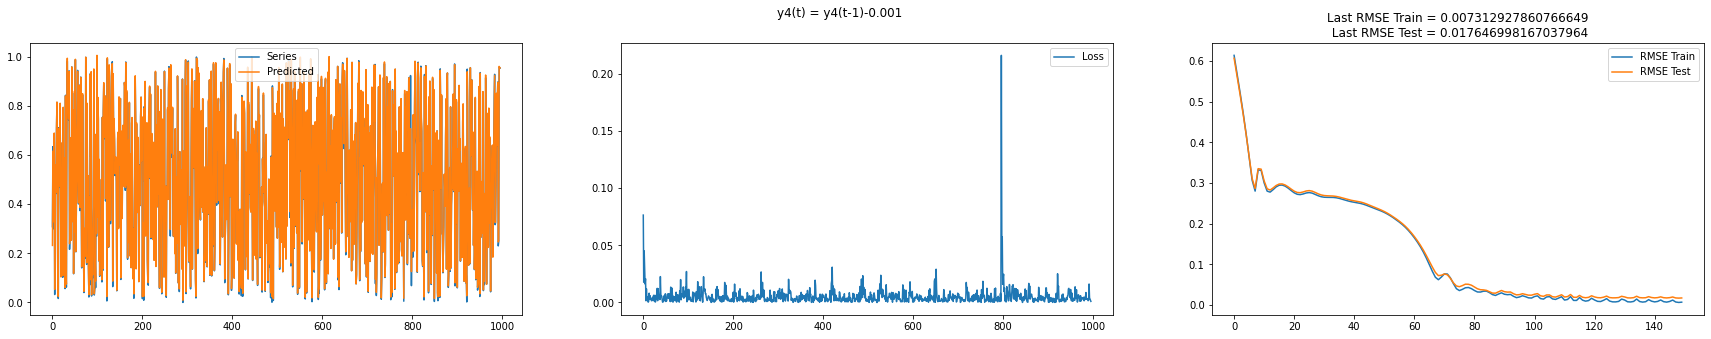

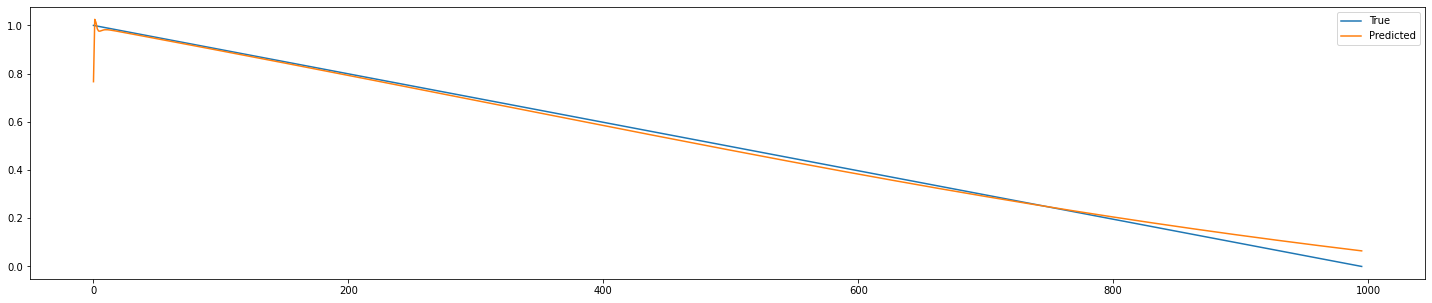

In [ ]:
executeLSTM("y4(t) = y4(t-1)-0.001", series4, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.5532656908035278 test loss: 0.5567196607589722
Epoch 10 train loss:0.29934462904930115 test loss: 0.2988787591457367
Epoch 20 train loss:0.28587815165519714 test loss: 0.2845141291618347
Epoch 30 train loss:0.27779436111450195 test loss: 0.2747584581375122
Epoch 40 train loss:0.2660260498523712 test loss: 0.26064491271972656
Epoch 50 train loss:0.24433811008930206 test loss: 0.237860307097435
Epoch 60 train loss:0.19823700189590454 test loss: 0.19151969254016876
Epoch 70 train loss:0.08952552825212479 test loss: 0.09895561635494232
Epoch 80 train loss:0.04898638650774956 test loss: 0.05906856432557106
Epoch 90 train loss:0.024094484746456146 test loss: 0.0421409085392952
Epoch 100 train loss:0.023946290835738182 test loss: 0.04147057235240936
Epoch 110 train loss:0.01640295423567295 test loss: 0.036091163754463196
Epoch 120 train loss:0.013476379215717316 test loss: 0.03362768515944481
Epoch 130 train loss:0.012317771092057228 test loss: 0.03207342326641083
Epoch 1

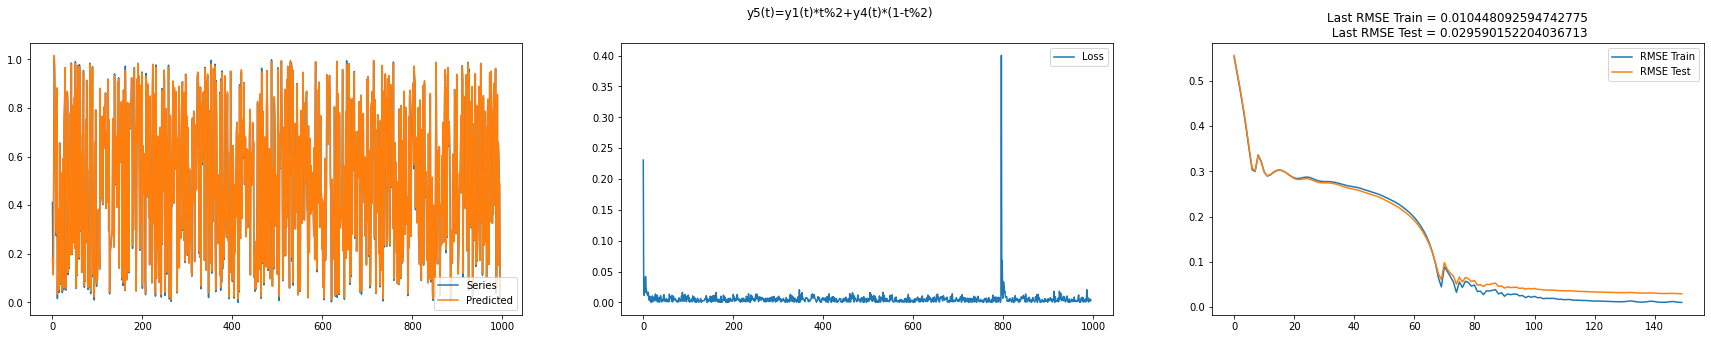

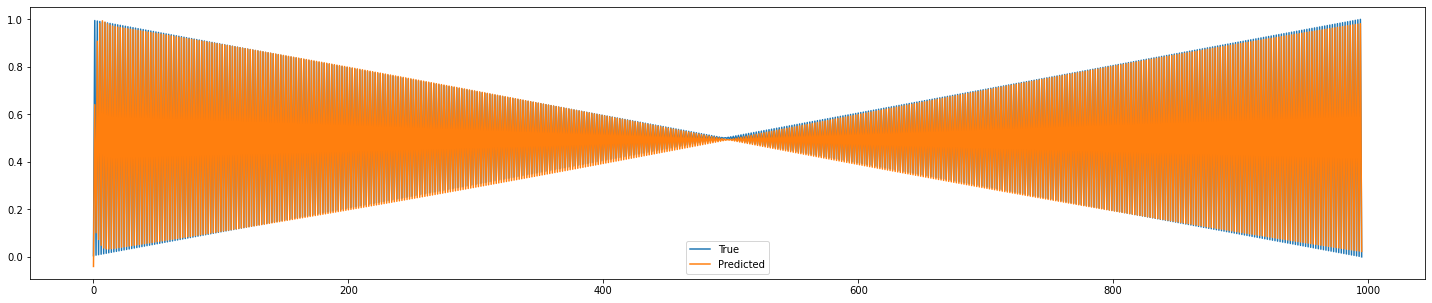

In [ ]:
executeLSTM("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.7366868257522583 test loss: 0.7009361386299133
Epoch 10 train loss:0.35184308886528015 test loss: 0.40228936076164246
Epoch 20 train loss:0.3205016255378723 test loss: 0.37822094559669495
Epoch 30 train loss:0.3106788098812103 test loss: 0.36603882908821106
Epoch 40 train loss:0.2947753071784973 test loss: 0.35362768173217773
Epoch 50 train loss:0.2643147110939026 test loss: 0.3206176459789276
Epoch 60 train loss:0.20836420357227325 test loss: 0.25811874866485596
Epoch 70 train loss:0.12429042905569077 test loss: 0.13625524938106537
Epoch 80 train loss:0.10537509620189667 test loss: 0.12289416790008545
Epoch 90 train loss:0.0971655622124672 test loss: 0.09848573803901672
Epoch 100 train loss:0.08898945897817612 test loss: 0.09793748706579208
Epoch 110 train loss:0.08087113499641418 test loss: 0.08071405440568924
Epoch 120 train loss:0.0747884064912796 test loss: 0.07530016452074051
Epoch 130 train loss:0.06579093635082245 test loss: 0.06953839212656021
Epoch 140 tr

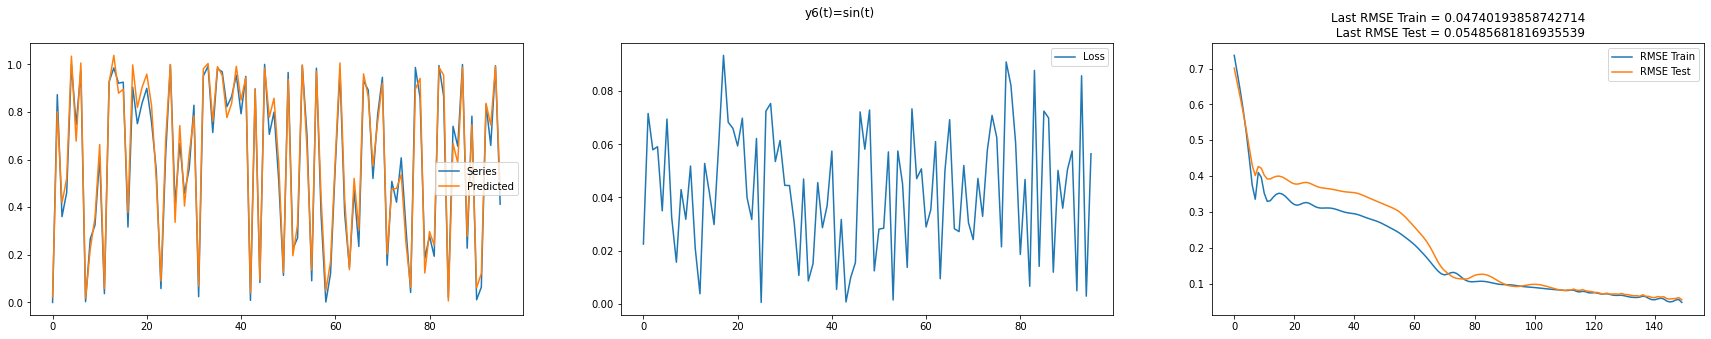

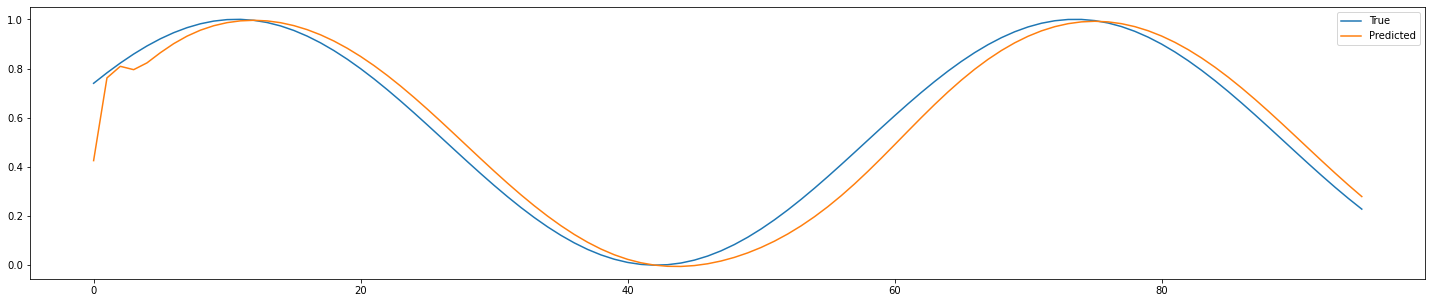

In [20]:
executeLSTM("y6(t)=sin(t)", series6, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)